In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import *
import numpy as np
%matplotlib inline

## Подготовка и визуализация данных

In [2]:
train_loader, valid_loader, test_loader = mnist(valid=10000, batch_size=50)

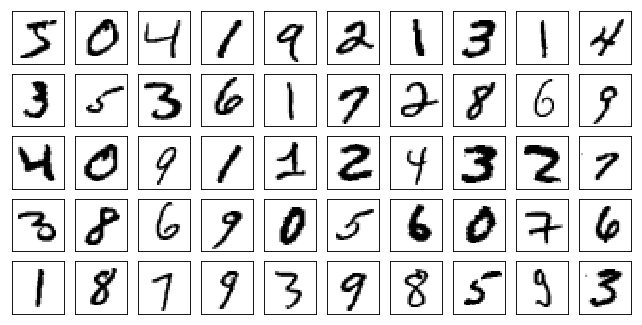

In [3]:
images = mnist_plotdata()
plot_mnist(images, (5, 10))

## Обучение классификатора

In [4]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(256)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)    
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [5]:
def train(epoch, models):
    loss_stats = np.empty((0,4))
    
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
       
        for model in models:
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()                
            
            
        if batch_idx % 200 == 0:
            print_stats(models, train_loader, epoch, batch_idx, data, train_size)            
            stats_line = np.array([m._loss.item() for m in models])
            loss_stats = np.vstack([loss_stats, stats_line])          
            
    else:
        batch_idx += 1
        print_stats(models, train_loader, epoch, batch_idx, data, train_size)
        stats_line = np.array([m._loss.item() for m in models])
        loss_stats = np.vstack([loss_stats, stats_line])
       
    epoch_loss = np.mean(loss_stats, axis=0)      
    return epoch_loss
       
        
def print_stats(models, train_loader, epoch, batch_idx, data, train_size):
    line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
    losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in enumerate(models)])
    print(line + losses)
        

In [6]:
models = [Net(False, False), Net(True, False), Net(False, True), Net(True, True)]

In [7]:
def test(models, loader):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = [0]*len(models)
    correct = [0]*len(models)
    with torch.no_grad():
        for data, target in loader:
            output = [m(data) for m in models]
            for i, m in enumerate(models):
                test_loss[i] += m.loss(output[i], target, size_average=False).item() # sum up batch loss
                pred = output[i].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[i] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for i in range(len(models)):
        test_loss[i] /= test_size
    correct_pct = [100. * c / test_size for c in correct]
    lines = '\n'.join([line(i, test_loss[i], correct[i], correct_pct[i]) for i in range(len(models))]) + '\n'
    report = 'Test set:\n' + lines
    
    print(report)
    
    return test_loss, correct_pct

In [19]:
epoch_train_loss = []
epoch_test_loss = []
epoch_test_acc = []

In [20]:
for epoch in range(1, 21):
    for model in models:
        model.train()
    train_loss_val = train(epoch, models)
    epoch_train_loss.append(train_loss_val)
    
    for model in models:
        model.eval()
    test_loss_val, test_acc_val = test(models, valid_loader)
    epoch_test_loss.append(test_loss_val)
    epoch_test_acc.append(test_acc_val)
    

/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/50000 (0%)]	Losses 0: 2.327425 1: 2.340549 2: 2.296613 3: 2.290284
Train Epoch: 1 [10000/50000 (20%)]	Losses 0: 0.528703 1: 0.646311 2: 0.522253 3: 0.682473
Train Epoch: 1 [20000/50000 (40%)]	Losses 0: 0.300755 1: 0.297055 2: 0.292518 3: 0.301515
Train Epoch: 1 [30000/50000 (60%)]	Losses 0: 0.491225 1: 0.382450 2: 0.479021 3: 0.388505
Train Epoch: 1 [40000/50000 (80%)]	Losses 0: 0.388524 1: 0.344619 2: 0.382316 3: 0.344652
Train Epoch: 1 [50000/50000 (100%)]	Losses 0: 0.210931 1: 0.185536 2: 0.231152 3: 0.204111
Test set:
0: Loss: 0.2578	Accuracy: 9232/10000 (92%)
1: Loss: 0.1998	Accuracy: 9418/10000 (94%)
2: Loss: 0.2527	Accuracy: 9243/10000 (92%)
3: Loss: 0.2102	Accuracy: 9383/10000 (93%)

Train Epoch: 2 [0/50000 (0%)]	Losses 0: 0.446509 1: 0.342857 2: 0.428970 3: 0.378852
Train Epoch: 2 [10000/50000 (20%)]	Losses 0: 0.185910 1: 0.140166 2: 0.172756 3: 0.162060
Train Epoch: 2 [20000/50000 (40%)]	Losses 0: 0.229983 1: 0.189725 2: 0.207024 3: 0.226461
Train Epoch: 2 [

Train Epoch: 12 [40000/50000 (80%)]	Losses 0: 0.075219 1: 0.045865 2: 0.056565 3: 0.055696
Train Epoch: 12 [50000/50000 (100%)]	Losses 0: 0.082602 1: 0.057633 2: 0.064620 3: 0.040889
Test set:
0: Loss: 0.0919	Accuracy: 9732/10000 (97%)
1: Loss: 0.0803	Accuracy: 9795/10000 (97%)
2: Loss: 0.0849	Accuracy: 9761/10000 (97%)
3: Loss: 0.0788	Accuracy: 9784/10000 (97%)

Train Epoch: 13 [0/50000 (0%)]	Losses 0: 0.049020 1: 0.014964 2: 0.047294 3: 0.018037
Train Epoch: 13 [10000/50000 (20%)]	Losses 0: 0.042093 1: 0.008380 2: 0.030662 3: 0.009727
Train Epoch: 13 [20000/50000 (40%)]	Losses 0: 0.012305 1: 0.002360 2: 0.006216 3: 0.011906
Train Epoch: 13 [30000/50000 (60%)]	Losses 0: 0.069471 1: 0.018460 2: 0.056218 3: 0.009554
Train Epoch: 13 [40000/50000 (80%)]	Losses 0: 0.011594 1: 0.068560 2: 0.008868 3: 0.022940
Train Epoch: 13 [50000/50000 (100%)]	Losses 0: 0.006807 1: 0.000464 2: 0.002929 3: 0.001421
Test set:
0: Loss: 0.0870	Accuracy: 9753/10000 (97%)
1: Loss: 0.0856	Accuracy: 9779/10000 (9

In [21]:
final_train_loss = np.array(epoch_train_loss)
final_test_loss = np.array(epoch_test_loss)
final_test_acc = np.array(epoch_test_acc)

In [22]:
torch.save(models[3], './model_classifier')

/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Вывод результатов

In [8]:
model = torch.load('./model_classifier')

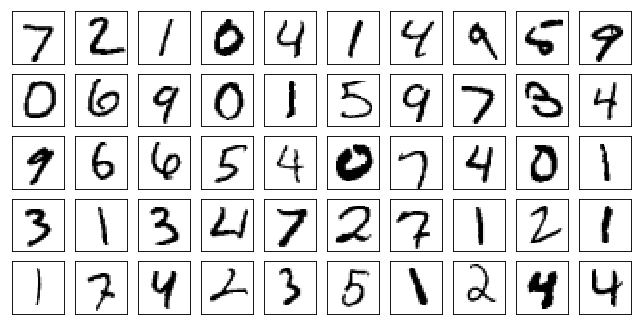

[tensor(7), tensor(2), tensor(1), tensor(0), tensor(4), tensor(1), tensor(4), tensor(9), tensor(5), tensor(9), tensor(0), tensor(6), tensor(9), tensor(0), tensor(1), tensor(5), tensor(9), tensor(7), tensor(3), tensor(4), tensor(9), tensor(6), tensor(6), tensor(5), tensor(4), tensor(0), tensor(7), tensor(4), tensor(0), tensor(1), tensor(3), tensor(1), tensor(3), tensor(4), tensor(7), tensor(2), tensor(7), tensor(1), tensor(2), tensor(1), tensor(1), tensor(7), tensor(4), tensor(2), tensor(3), tensor(5), tensor(1), tensor(2), tensor(4), tensor(4)]


In [9]:
data, _ = next(iter(test_loader))
output = model.forward(data)
predictions = [output[i].argmax() for i in range(50)]
plot_mnist(data.data.numpy(), (5, 10))

print (predictions)

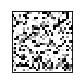

In [16]:
data, _ = next(iter(test_loader))
img = torch.randn((1, 784)).view(-1, 1, 28, 28)
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (1, 1))


In [17]:
from torch.autograd import Variable

def generate_image(img, cl):
    
    gen_img_par = Variable(img, requires_grad=True)       
    target = torch.ones((1), dtype=torch.long) * cl
    steps_since_lr_decreased = 0
    
    loss_stats = []    
    lr=1e-2

    for i in range(1, 1000001):  
                
        out = model.forward(gen_img_par)      
                 
        gen_optim = optim.RMSprop([gen_img_par], lr=lr, weight_decay=0.)    
        gen_optim.zero_grad()
        loss = F.cross_entropy(out, target) 
        loss.backward()                   
        gen_optim.step()
        
        if i % 5000 == 0:    
            print ("Iteration {}: loss={} prediction={} lr={}".format(i,loss, out.argmax(), lr))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
            
            #print("PRED=", out.argmax())
            #print("OUT=", out)
            #print("TR=", target)
                        
            if len(loss_stats) > 10:    
                down = False    
                for k in range(2, 7):    
                    if ls < loss_stats[-k]:
                        down = True
                        break
                # Loss is rising for 5 last epochs - decrease LR
                if not down and steps_since_lr_decreased > 10:
                    lr = lr * 0.5
                    steps_since_lr_decreased = 0
                    print ("Decreasing LR ..")
                   # if lr < 1e-7:
                   #     print ("Stop ..")
                   #     break
                
                steps_since_lr_decreased += 1


        if i % 50000 == 0:
            to_plot = gen_img_par.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (1, 1))
                        
    return gen_img_par, loss_stats      


Iteration 5000: loss=2.431832513138943e-11 prediction=6 lr=0.01
Iteration 10000: loss=1.20525811553307e-11 prediction=6 lr=0.01
Iteration 15000: loss=8.049561017742235e-12 prediction=6 lr=0.01
Iteration 20000: loss=6.057154777749929e-12 prediction=6 lr=0.01
Iteration 25000: loss=4.859224134179385e-12 prediction=6 lr=0.01
Iteration 30000: loss=4.057421065795097e-12 prediction=6 lr=0.01
Iteration 35000: loss=3.4845459850885163e-12 prediction=6 lr=0.01
Iteration 40000: loss=3.0540014961388806e-12 prediction=6 lr=0.01
Iteration 45000: loss=2.7178259642823832e-12 prediction=6 lr=0.01
Iteration 50000: loss=2.4482638139033952e-12 prediction=6 lr=0.01


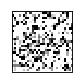

Iteration 55000: loss=2.227773521212839e-12 prediction=6 lr=0.01
Iteration 60000: loss=2.043476499125063e-12 prediction=6 lr=0.01
Iteration 65000: loss=1.887601186467691e-12 prediction=6 lr=0.01
Iteration 70000: loss=1.7539303343028223e-12 prediction=6 lr=0.01
Iteration 75000: loss=1.638245095136881e-12 prediction=6 lr=0.01
Iteration 80000: loss=1.5372147998959917e-12 prediction=6 lr=0.01
Iteration 85000: loss=1.4477308241112041e-12 prediction=6 lr=0.01
Iteration 90000: loss=1.368904989362818e-12 prediction=6 lr=0.01
Iteration 95000: loss=1.297850715786808e-12 prediction=6 lr=0.01
Iteration 100000: loss=1.234345958778249e-12 prediction=6 lr=0.01


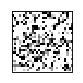

Iteration 105000: loss=1.176614361497741e-12 prediction=6 lr=0.01
Iteration 110000: loss=1.1239897901305085e-12 prediction=6 lr=0.01
Iteration 115000: loss=1.0758061108617767e-12 prediction=6 lr=0.01
Iteration 120000: loss=1.0311751452718454e-12 prediction=6 lr=0.01
Iteration 125000: loss=9.905409825705647e-13 prediction=6 lr=0.01
Iteration 130000: loss=9.527933997333093e-13 prediction=6 lr=0.01
Iteration 135000: loss=9.179323967600794e-13 prediction=6 lr=0.01
Iteration 140000: loss=8.850697952311748e-13 prediction=6 lr=0.01
Iteration 145000: loss=8.548717289613705e-13 prediction=6 lr=0.01
Iteration 150000: loss=8.266720641358916e-13 prediction=6 lr=0.01


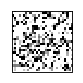

Iteration 155000: loss=8.002487561498128e-13 prediction=6 lr=0.01
Iteration 160000: loss=7.756018050031344e-13 prediction=6 lr=0.01
Iteration 165000: loss=7.522871214860061e-13 prediction=6 lr=0.01
Iteration 170000: loss=7.30526750203353e-13 prediction=6 lr=0.01
Iteration 175000: loss=7.096545573404001e-13 prediction=6 lr=0.01
Iteration 180000: loss=6.898925875020723e-13 prediction=6 lr=0.01
Iteration 185000: loss=6.714628852932947e-13 prediction=6 lr=0.01
Iteration 190000: loss=6.536993168992922e-13 prediction=6 lr=0.01
Iteration 195000: loss=6.372680161348399e-13 prediction=6 lr=0.01
Iteration 200000: loss=6.217248937900877e-13 prediction=6 lr=0.01


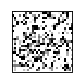

Iteration 205000: loss=6.068479052601106e-13 prediction=6 lr=0.01
Iteration 210000: loss=5.928590951498336e-13 prediction=6 lr=0.01
Iteration 215000: loss=5.795364188543317e-13 prediction=6 lr=0.01
Iteration 220000: loss=5.668798763736049e-13 prediction=6 lr=0.01
Iteration 225000: loss=5.551115123125783e-13 prediction=6 lr=0.01
Iteration 230000: loss=5.435651928564766e-13 prediction=6 lr=0.01
Iteration 235000: loss=5.329070518200751e-13 prediction=6 lr=0.01
Iteration 240000: loss=5.222489107836736e-13 prediction=6 lr=0.01
Iteration 245000: loss=5.122569035620472e-13 prediction=6 lr=0.01
Iteration 250000: loss=5.027089855502709e-13 prediction=6 lr=0.01


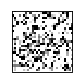

Iteration 255000: loss=4.933831121434196e-13 prediction=6 lr=0.01
Iteration 260000: loss=4.845013279464183e-13 prediction=6 lr=0.01
Iteration 265000: loss=4.760636329592671e-13 prediction=6 lr=0.01
Iteration 270000: loss=4.67847982577041e-13 prediction=6 lr=0.01
Iteration 275000: loss=4.600764214046649e-13 prediction=6 lr=0.01
Iteration 280000: loss=4.525269048372138e-13 prediction=6 lr=0.01
Iteration 285000: loss=4.454214774796128e-13 prediction=6 lr=0.01
Iteration 290000: loss=4.383160501220118e-13 prediction=6 lr=0.01
Iteration 295000: loss=4.3165471197426086e-13 prediction=6 lr=0.01
Iteration 300000: loss=4.2521541843143495e-13 prediction=6 lr=0.01


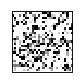

Iteration 305000: loss=4.1877612488860905e-13 prediction=6 lr=0.01
Iteration 310000: loss=4.1255887595070817e-13 prediction=6 lr=0.01
Iteration 315000: loss=4.0678571622265736e-13 prediction=6 lr=0.01
Iteration 320000: loss=4.0101255649460654e-13 prediction=6 lr=0.01
Iteration 325000: loss=3.9546144137148076e-13 prediction=6 lr=0.01
Iteration 330000: loss=3.89910326248355e-13 prediction=6 lr=0.01
Iteration 335000: loss=3.8480330033507926e-13 prediction=6 lr=0.01
Iteration 340000: loss=3.7969627442180354e-13 prediction=6 lr=0.01
Iteration 345000: loss=3.745892485085278e-13 prediction=6 lr=0.01
Iteration 350000: loss=3.6992631180510216e-13 prediction=6 lr=0.01


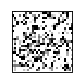

Iteration 355000: loss=3.6548541970660153e-13 prediction=6 lr=0.01
Iteration 360000: loss=3.608224830031759e-13 prediction=6 lr=0.01
Iteration 365000: loss=3.5638159090467525e-13 prediction=6 lr=0.01
Iteration 370000: loss=3.5216274341109965e-13 prediction=6 lr=0.01
Iteration 375000: loss=3.481659405224491e-13 prediction=6 lr=0.01
Iteration 380000: loss=3.4416913763379853e-13 prediction=6 lr=0.01
Iteration 385000: loss=3.4017233474514796e-13 prediction=6 lr=0.01
Iteration 390000: loss=3.361755318564974e-13 prediction=6 lr=0.01
Iteration 395000: loss=3.3240077357277187e-13 prediction=6 lr=0.01
Iteration 400000: loss=3.2884805989397137e-13 prediction=6 lr=0.01


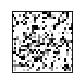

Iteration 405000: loss=3.2529534621517087e-13 prediction=6 lr=0.01
Iteration 410000: loss=3.2174263253637037e-13 prediction=6 lr=0.01
Iteration 415000: loss=3.1818991885756986e-13 prediction=6 lr=0.01
Iteration 420000: loss=3.1508129438861943e-13 prediction=6 lr=0.01
Iteration 425000: loss=3.11972669919669e-13 prediction=6 lr=0.01
Iteration 430000: loss=3.0886404545071855e-13 prediction=6 lr=0.01
Iteration 435000: loss=3.057554209817681e-13 prediction=6 lr=0.01
Iteration 440000: loss=3.028688411177427e-13 prediction=6 lr=0.01
Iteration 445000: loss=2.999822612537173e-13 prediction=6 lr=0.01
Iteration 450000: loss=2.970956813896919e-13 prediction=6 lr=0.01


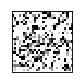

Iteration 455000: loss=2.942091015256665e-13 prediction=6 lr=0.01
Iteration 460000: loss=2.915445662665661e-13 prediction=6 lr=0.01
Iteration 465000: loss=2.8910207561239076e-13 prediction=6 lr=0.01
Iteration 470000: loss=2.864375403532904e-13 prediction=6 lr=0.01
Iteration 475000: loss=2.8399504969911504e-13 prediction=6 lr=0.01
Iteration 480000: loss=2.815525590449397e-13 prediction=6 lr=0.01
Iteration 485000: loss=2.788880237858393e-13 prediction=6 lr=0.01
Iteration 490000: loss=2.76667577736589e-13 prediction=6 lr=0.01
Iteration 495000: loss=2.7422508708241367e-13 prediction=6 lr=0.01
Iteration 500000: loss=2.7200464103316335e-13 prediction=6 lr=0.01


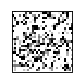

Iteration 505000: loss=2.6978419498391304e-13 prediction=6 lr=0.01
Iteration 510000: loss=2.6756374893466273e-13 prediction=6 lr=0.01
Iteration 515000: loss=2.6556534749033744e-13 prediction=6 lr=0.01
Iteration 520000: loss=2.6356694604601216e-13 prediction=6 lr=0.01
Iteration 525000: loss=2.6134649999676185e-13 prediction=6 lr=0.01
Iteration 530000: loss=2.5934809855243657e-13 prediction=6 lr=0.01
Iteration 535000: loss=2.573496971081113e-13 prediction=6 lr=0.01
Iteration 540000: loss=2.5557334026871104e-13 prediction=6 lr=0.01
Iteration 545000: loss=2.5357493882438575e-13 prediction=6 lr=0.01
Iteration 550000: loss=2.5157653738006047e-13 prediction=6 lr=0.01


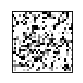

Iteration 555000: loss=2.498001805406602e-13 prediction=6 lr=0.01
Iteration 560000: loss=2.4802382370125997e-13 prediction=6 lr=0.01
Iteration 565000: loss=2.462474668618597e-13 prediction=6 lr=0.01
Iteration 570000: loss=2.4447111002245947e-13 prediction=6 lr=0.01
Iteration 575000: loss=2.426947531830592e-13 prediction=6 lr=0.01
Iteration 580000: loss=2.41140440948584e-13 prediction=6 lr=0.01


In [ ]:
new_image_randn = generate_image(img, 6)